# Appendix 1. Ellipsoidal variation
## 1 Overview: the effect of ellipsoidal variation on the eclipse depth

Ellipsoidal variation changes the baseline curvature during the eclipse making an eclipse appear deeper than it actually is if ellipsoidal variation is not taken into account.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
from uncertainties import ufloat, umath
from pytransit import EclipseModel

from src.kelt1 import LDPSetCreator, filters, filter_names, kelt1_m, star_m, mj2kg, ms2kg, star_teff

In [4]:
a = 3.639
p = 1.22
tec = 0.5*p

In [5]:
em = EclipseModel()
time = linspace(tec-0.25, tec+0.25, 1500)
em.set_data(time)

In [6]:
fec = em.evaluate(0.1, 0.0, p, a, 0.5*pi) - 1
aev = 0.05
fev = - aev*cos(2 * time * (2*pi) / p)

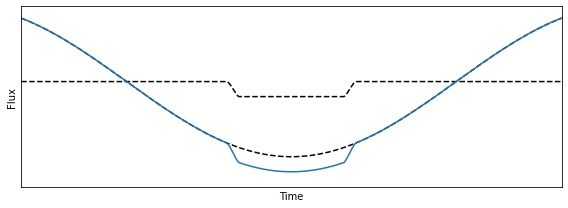

In [7]:
fig, ax = subplots(figsize=(8,3))
ax.plot(time-tec, 1 + fec, 'k--')
ax.plot(time-tec, 1 + fev, 'k--')
ax.plot(time-tec, 1 + fec+fev)
setp(ax, xlim=(-0.25, 0.25), ylim=(0.93, 1.05), xlabel='Time', ylabel='Flux', xticks=[], yticks=[])
fig.tight_layout()
fig.savefig('ev_issue_1.png', dpi=300)

The apparent eclipse depth $\Delta F_\mathrm{App}$ is significantly deeper than the true eclipse depth $\Delta F_\mathrm{True}$.

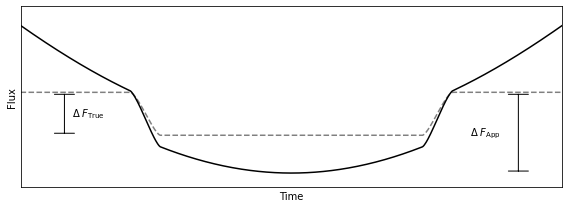

In [8]:
fig, ax = subplots(figsize=(8,3))
ax.plot(time-tec, 1 + fec, '--', c='0.5')
ftot = 1.0412 + fec+fev
fmin = ftot.min()
ax.plot(time-tec, ftot, 'k')
ax.annotate('', (-0.084, 0.99), xytext=(-0.084,1.0), arrowprops=dict(arrowstyle='|-|'))
ax.text(-0.069, 0.995, '$\Delta\; F_\mathrm{True}$', va='center', ha='right')
ax.annotate('', (0.084, 1.0), xytext=(0.084, ftot.min()), arrowprops=dict(arrowstyle='|-|'))
ax.text(0.066, 0.5*(1.0+fmin), '$\Delta\; F_\mathrm{App}$', va='center', ha='left')
setp(ax, xlim=(-0.1, 0.1), ylim=(0.978, 1.02), xlabel='Time', ylabel='Flux', xticks=[], yticks=[])
fig.tight_layout()
fig.savefig('ev_issue_2.png', dpi=300)

## 2 Theoretical EV amplitudes

The EV amplitude is a product of planet-star mass ratio, semi-major axis, orbital eccentricity and inclination, and gravity and limb darkening.

$$
A_\mathrm{ev} = \beta \frac{M}{a_\mathrm{s}^3 M_\star} \frac{1 + e\cos \nu}{1 - e^2} \sin(i)^3 \approx \beta \frac{l}{a_\mathrm{s}^3} \sin(i)^3,
$$

$$
\beta = 0.12 \frac{(15 + u)(1 + g)}{3 - u},
$$

Where $u$ is the linear limb darkening coefficient and $g$ the gravity darkening coefficient. 

In the case of KELT-1b, we have a good planet-star mass ratio estimate thanks to RV measurements and the orbital eccentricity is small enough for the orbit to be considered circular. We also have a decent estimate of the scaled semi-major axis, the limb darkening coefficients we can calculate with the LDTk, and the gravity darkening coefficients can be obtained from [Claret2021](https://iopscience.iop.org/article/10.3847/2515-5172/abdcb3),  [Claret2017](https://ui.adsabs.harvard.edu/abs/2017A%26A...600A..30C/abstract), and [Claret2011](https://www.aanda.org/articles/aa/full_html/2011/05/aa16451-11/aa16451-11.html).


In [114]:
def beta(u, g):
    return 0.15*((15+u)*(1+g))/(3-u)

In [157]:
a = (kelt1_m*mj2kg)/(aor**3*star_m*ms2kg) * umath.sin(ufloat(radians(86.7), radians(0.6)))**2

### Gravity darkening: *TESS*

In [160]:
df = pd.read_csv('data/gravity_darkening_tess_claret_2017.tsv', sep='\t', comment='#')
gtess = ufloat(df.y.mean(), df.y.std())
print(gtess)

0.219+/-0.005


### Gravity darkening: *CHEOPS* (ATLAS)

In [161]:
df = pd.read_csv('/media/media/data/rnaasabdcb3/TABLE14', delim_whitespace=True, skiprows=1)
df = df.iloc[::2]
df.columns = ['ZR', 'Vel', 'logg', 'logTeff', 'y1']

mlogg = (df.logg >= 4.) & (df.logg <= 4.5)
mteff = df.logTeff == 3.813
m = mlogg & mteff

gcheops = ufloat((df[m].y1 / 4).mean(), (df[m].y1 / 4).std())
print(gcheops)

0.244+/-0.006


### Gravity darkening: final coefficients

In [102]:
gcheops = ufloat(0.2439, 0.0056)
gtess = ufloat(0.2191, 0.0051)
gh = 0.089
gk = 0.083
g36 = 0.077
g45 = 0.084

### Limb darkening

In [103]:
sc = LDPSetCreator((6516., 49.), (4.228, 0.02), (0.052, 0.079), filters=filters, dataset='visir-lowres')
ps = sc.create_profiles()
ps.set_uncertainty_multiplier(10)

In [129]:
ldc, lde = ps.coeffs_ln()

### Theoretical EV amplitudes

In [159]:
for f, u, ue,g in zip(filter_names, ldc, lde,[gcheops, gtess, gh, gk, g36, g45]):
    print(f"{f:6s} {1e6*a*beta(ufloat(u, ue), g)}")

CHEOPS 479+/-30
TESS   442+/-28
H      357+/-23
Ks     351+/-22
36um   343+/-22
45um   341+/-22



## 3 EV amplitude ratios

In the case of KELT-1b, we have a high-quality light curve covering the full phase observed by TESS. The TESS photometry provides a good estimate for the ellipsoidal variation amplitude in the TESS passband.
Only the gravity darkening and limb darkening are passband dependent, all the other parameters are the same for TESS and CHEOPS observations. Thus, we can calculate the EV amplitude in the CHEOPS passband from the TESS EV amplitude

In [149]:
for f, u, ue,g in zip(filter_names, ldc, lde,[gcheops, gtess, gh, gk, g36, g45]):
    print(f"{f:6s} {beta(ufloat(u, ue), g) / beta(ufloat(ldc[1], lde[1]), gtess)}")

CHEOPS 1.083+/-0.007
TESS   1.0000+/-0.0018
H      0.807+/-0.004
Ks     0.7953+/-0.0035
36um   0.7752+/-0.0034
45um   0.7727+/-0.0034


---

<center>&copy; 2021 Hannu Parviainen</center>